<center>
    <h1>Predicting Communicative Intention in Code Review Questions</h1>
    <h3>Lab 2 || Data-driven Software Engineering || Offered by Dr. Shaowei Wang</h3>
    <h3>University of Manitoba - Fall 2020</h3>
    <h3>Pooya Nikbakht (#7864707)</h3>
</center>

<br />
<br />
<br />
<br />
<br />


# Setting Initial Parameters of The Program
<a name="imp_lib"></a>

set the source file of DB:

In [1]:
#Dataset sources (on Github):
csv_db_address = 'https://github.com/Pooya-Nikbakht/SE-Lab2/raw/main/lab2_db_keyQuestion.csv'

set what percentage of the whole dataset should be considered as the test dataset:

In [2]:
#test dataset size
test_split_portion = 0.25  #0.25 for considering the last 25% of the whole dataset as the test dataset

set which pre-processing jobs should be done for question 1 and 2 in addition to word tokenizing?

In [3]:
#Stemming the questions before tokenizing?
do_stemming = False

#Removing the stop words from the questions before tokenizing?
remove_stop_words = False

#Using keyQuestions instead of rawQuestions to train the models
use_keyQuestions_to_train = True  #if False, it will use rawQuestions to train the models

set which new attributes should be considered for Questions 2 and Question 3:

In [4]:
#sentiment attribute
add_sentiment = True

#question-length attribute
add_question_lengths = True

set which classification methods should be used to build the classifiers:

In [5]:
#The first method with value "True" is applied

#- Random Forest?
use_random_forest = True

#- XGBoost?
use_xgboost = False

#- k-Nearest neighbors?
use_knn = False

# Imorting Libraries
<a name="imp_lib"></a>

In [6]:
#Arrays and Matrices Libraries
import numpy as np 

#Plotting Libraries
import matplotlib.pyplot as plt 

#Data Analysis Libraries
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
import sys
!{sys.executable} -m pip install xgboost
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification

from sklearn.feature_extraction.text import CountVectorizer

from nltk.stem.porter import PorterStemmer

import nltk
from nltk.corpus import stopwords 
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from sklearn.model_selection import RandomizedSearchCV, train_test_split


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gadalab\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Definition of functions
<a name="init_param"></a>

In [7]:
#a fucntion to transform a raw label to its corresponding final label
def label(str):
    switch={
        'suggestion':'suggestion',
        'request for action':'request',
        'request for confirmation':'request',
        'request for clarification':'request',
        'request for information':'request',
        'request for opinion':'request',
        'request for rationale':'request',
        'anger':'attitude and emotion',
        'criticism':'attitude and emotion',
        'surprise':'attitude and emotion',
        'rhetorical question':'rhetorical question',
        'hypothetical scenario':'hypothetical scenario',
     }
    return switch.get(str,"others")


#a function to transform all labels of input array to the corresponding final labels
def modifyLabels(inputArray, labelColumnIndex):
    tmpArray = inputArray.copy()
    for i in range(len(tmpArray)):
        tmpArray[i][labelColumnIndex] = label(tmpArray[i][labelColumnIndex])
    
    return tmpArray


#a fuction that applies stemming to the input array and return the stemmed array
def get_stemmed_text(texts):
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in texts]


#a fuction to calculate the lenght of each element of an input string array
def getLenghts(inputArr):
    rowLenghts = inputArr.copy()
    for i in range(len(rowLenghts)):
        rowLenghts[i] = len(rowLenghts[i])
            
    return rowLenghts


#a function to calculate the sentiment of each array's element. Return value is a list of dictionaries
#-- {'neg': a, 'neu': b, 'pos': c, 'compound': d} where a, b, c, and d are fload values.
def getSentiment(inputArr, justCompound = False):
    analyzer = SentimentIntensityAnalyzer()
    
    rowSentiments = []
    for i in range(len(inputArr)):
        if(justCompound):
            tmpDic = analyzer.polarity_scores(inputArr[i])
            tmpDic.pop("neg")
            tmpDic.pop("neu")
            tmpDic.pop("pos")
            rowSentiments.append(tmpDic)
        else:
            rowSentiments.append(analyzer.polarity_scores(inputArr[i]))
            
    return rowSentiments


#a function to convert categorical labels into a binary numerical form
def encodeLabels(inputLabels):
    encodeList = []
    for i in range(len(inputLabels)):
        if(inputLabels[i] == "request"):
            encodeList.append([1,0,0,0,0])
        if(inputLabels[i] == "suggestion"):
            encodeList.append([0,1,0,0,0])
        if(inputLabels[i] == "attitude and emotion"):
            encodeList.append([0,0,1,0,0])
        if(inputLabels[i] == "rhetorical question"):
            encodeList.append([0,0,0,1,0])
        if(inputLabels[i] == "hypothetical scenario"):
            encodeList.append([0,0,0,0,1])
    
    return encodeList


# Preparing initial raw train and test datasetes

### Importing the original dataset
<a name="imp_data"></a>

In [8]:
#reading the raw dataset as a data frame
raw_db_df = pd.read_csv(csv_db_address)

#converting the target db to array
raw_db = raw_db_df.to_numpy()

#printing
raw_db_df.sample(5)

,inline-comment-id,# Comment,Question,Main Question,Final Label
195,7ffd0472_1546d6df,196,Could you name this something that indicates i...,Could you name this something that indicates i...,request for action
53,503c1cf2_352644cd,54,"cut this part?\r\n\r\nmaybe just say ""lib.so"" ...",cut this part?,suggestion
15,63258a42_59a0e39e,16,Should this be checked at the point where trac...,Or verifyTrack() called in more places?,request for clarification
284,bcb0b30a_9bb64b94,285,"What about your comment on simulatePhi, is it ...","What about your comment on simulatePhi, is it ...",request for confirmation
96,a46156bd_1a1a193a,97,What would the right solution look like after ...,What would the right solution look like after ...,request for clarification


### Modifying labels

Printing all distinct labels of the raw database:

In [9]:
#printing all distinct labels
np.unique(raw_db[:,-1])

array(['action', 'anger', 'criticism', 'discarded',
       'hypothetical scenario', 'request for action',
       'request for clarification', 'request for confirmation',
       'request for information', 'request for opinion',
       'request for rationale', 'rhetorical question', 'suggestion',
       'surprise'], dtype=object)

Changing the raw labels to target labels:

In [10]:
#modifying labels to the target labels and update the array db
raw_db = modifyLabels(raw_db, -1)

#update dataFrame db
raw_db_df = pd.DataFrame(raw_db)
raw_db_df = raw_db_df.rename(columns={0: "commentID", 1: "comment#", 2: "rawQuestion", 3: "keyQuestion", 4: "Label"})
raw_db_df.sample(5)

,commentID,comment#,rawQuestion,keyQuestion,Label
220,9d9da072_e549be31,221,I don't see this was a previous TODO. Can you ...,Can you please do the usual process?,request
368,7f49844c_3252b096,369,is this right? (i was trying to work out a cas...,is this right?,request
345,6aac9bb5_a1479832,346,I think that generalizing this is a good idea ...,(32|64) why not just 32|64?,suggestion
211,38858659_05e20219,212,Could you make this an argument rather than a ...,Could you make this an argument rather than a ...,suggestion
438,c86c6f4a_23874ab5,439,"This size_ includes the size of the header, co...",Add this to the comment?,request


Printing all updated distinct labels:

In [11]:
np.unique(raw_db[:,-1])

array(['attitude and emotion', 'hypothetical scenario', 'others',
       'request', 'rhetorical question', 'suggestion'], dtype=object)

Removing records with labels of no interest (label "others"):

In [12]:
#removing the records with the labels other than our target labels
raw_db_df = raw_db_df[raw_db_df.Label != "others"]

#reset the indexes
raw_db_df = raw_db_df.reset_index(drop=True)

#update processed_train_db
raw_db = np.array(raw_db_df)


Printing all distinct final labels:

In [13]:
np.unique(raw_db[:,-1])

array(['attitude and emotion', 'hypothetical scenario', 'request',
       'rhetorical question', 'suggestion'], dtype=object)

## Forming initial train and test datasets
<a name="imp_data"></a>

Spliting the raw input db into training and test datasets:

In [14]:
#Spliting the input db into training and test datasets:
raw_train_db, raw_test_db, raw_train_labels, raw_test_labels = train_test_split(raw_db[:],
                                                                    raw_db_df.iloc[:, -1:].to_numpy()[:],
                                                                    test_size=test_split_portion, shuffle=False) 

#converting train db into data frame
raw_train_db_df = pd.DataFrame(raw_train_db)
raw_train_db_df = raw_train_db_df.rename(columns={0: "commentID", 1: "comment#", 2: "rawQuestion",
                                                  3: "keyQuestion", 4: "Label"})

#converting test db into data frame
raw_test_db_df = pd.DataFrame(raw_test_db)
raw_test_db_df = raw_test_db_df.rename(columns={0: "commentID", 1: "comment#", 2: "rawQuestion",
                                                3: "keyQuestion", 4: "Label"})


Printing the size of raw test and train datasets:

In [15]:
#Printing the size of train dataset
print("size of raw train dataset: " + str(len(raw_train_db)) + " records out of " + str(len(raw_db)))

#Printing the size of test dataset
print("size of raw test dataset: " + str(len(raw_test_db)) + " records out of " + str(len(raw_db)))

size of raw train dataset: 369 records out of 492
size of raw test dataset: 123 records out of 492


# Basic β-Preprocessing (tokenizing the rawQuestions)

### Forming target train dataset

In [16]:
#creating a new data frame
basicProcessed_train_db_df = pd.DataFrame()

#adding the raw questions from train db
basicProcessed_train_db_df['rawQuestion'] = raw_train_db_df["rawQuestion"]

#adding corresponding labels
basicProcessed_train_db_df['Label'] = raw_train_db_df["Label"]

#converting the target db to array
basicProcessed_train_db = basicProcessed_train_db_df.to_numpy()

basicProcessed_train_db_df

,rawQuestion,Label
0,is this what they intended? don't they really ...,request
1,is this what they intended? don't they really ...,attitude and emotion
2,Don't we need to increment 'i' in the else cas...,suggestion
3,i can't see anywhere where this is set to fals...,suggestion
4,are you sure you want to include this source f...,attitude and emotion
...,...,...
364,why All? There is only 1 right? Also what does...,request
365,why All? There is only 1 right? Also what does...,request
366,why All? There is only 1 right? Also what does...,request
367,Is the issue that MethodHelper contains a Hand...,request


### Tokenizing rawQuestions

Tokenize while removing stop words:

In [17]:
#building the basic_vectorizer
basic_vectorizer = CountVectorizer(analyzer='word')

#tokenize while removing stop words and create the word vectors
basic_word_vectors = basic_vectorizer.fit_transform(basicProcessed_train_db[:,0])

#print all tokens
print(basic_vectorizer.get_feature_names())


['0x0', '0x0101', '0x0104', '10', '100', '1175', '1202', '13', '157', '168', '17', '19', '1ghz', '20', '2001', '270', '278137', '32', '52', '5mhz', '64', '64bits', '65535', '936', '937', '950â', '951', '9ms', '__android_api__', '__bionic_fortify', '__nvmap_page_pool_fill_lots_locked', '__reserved', '_hoping_', '_really_', '_should_', '_ssse3', 'aaargh', 'abc', 'abi', 'able', 'about', 'above', 'abstraction', 'acceptable', 'accepted', 'access', 'accesses', 'accessible', 'accident', 'account', 'across', 'act', 'acting', 'actions', 'actively', 'acts', 'actual', 'actually', 'adaptor', 'adaptor_bus_', 'adb_basename', 'adb_trace_init', 'adb_unlink', 'add', 'addattachedwindowtolistlocked', 'added', 'adding', 'additional', 'address', 'address_sanitizer_runtime_library', 'addstoragelocked', 'adjacent', 'adjust', 'adtplugin', 'af_inet', 'af_inet6', 'affect', 'afraid', 'after', 'again', 'against', 'ages', 'agree', 'align', 'alignment', 'alive', 'all', 'allocate', 'allow', 'along', 'already', 'also

Creating a new db including word vectors:

In [18]:
#creating a new df containing the word vectors
basicProcessed_vector_train_db_df = pd.DataFrame(np.array(basic_word_vectors.toarray()))

#adding the label to the end
basicProcessed_vector_train_db_df['Label'] = basicProcessed_train_db_df["Label"]

#converting the new df to array
basicProcessed_vector_train_db = np.array(basicProcessed_vector_train_db_df)

#printing some random records
basicProcessed_vector_train_db_df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,1630,1631,1632,1633,1634,1635,1636,1637,1638,Label
256,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,request
35,0,0,0,0,0,0,0,0,0,0,...,1,1,2,0,0,0,0,0,0,request
328,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,suggestion
252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,request
135,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,request


### Forming the final train and test datasets based on basic pre-processing


In [19]:
#train attributes
basicProcessed_train_data = np.array(basicProcessed_vector_train_db_df.iloc[:, :-1])

#train labels
basicProcessed_train_labels = np.array(basicProcessed_vector_train_db_df.iloc[:, -1:])

#vectorizing raw questions in the test dataset into word vectors
basicProcessed_test_data = basic_vectorizer.transform(raw_test_db_df["rawQuestion"])
#test attributes: converting the vectors into array
basicProcessed_test_data = basicProcessed_test_data.toarray()

#test labels
basicProcessed_test_labels = np.array(raw_test_db_df.iloc[:, -1:])


In [20]:
print("final train data based on basic pre-processing:")
pd.DataFrame(basicProcessed_train_data)

final train data based on basic pre-processing:


,0,1,2,3,4,5,6,7,8,9,...,1629,1630,1631,1632,1633,1634,1635,1636,1637,1638
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
print("final test data based on basic pre-processing:")
pd.DataFrame(basicProcessed_test_data)

final test data based on basic pre-processing:


,0,1,2,3,4,5,6,7,8,9,...,1629,1630,1631,1632,1633,1634,1635,1636,1637,1638
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Advanced α-Preprocessor (stemming, stopWords, and tokenizing)

### Forming target train dataset

In [22]:
#creating a new data frame
processed_train_db_df = pd.DataFrame()

#adding questions from train db
if(use_keyQuestions_to_train):
    processed_train_db_df['Question'] = raw_train_db_df["keyQuestion"]
else:
    processed_train_db_df['Question'] = raw_train_db_df["rawQuestion"]


#adding corresponding labels
processed_train_db_df['Label'] = raw_train_db_df["Label"]

#converting the target db to array
processed_train_db = processed_train_db_df.to_numpy()

processed_train_db_df

,Question,Label
0,is this what they intended?,request
1,don't they really want $(TARGET_OUT_DATA_NATIV...,attitude and emotion
2,Don't we need to increment 'i' in the else cas...,suggestion
3,should we just adjust the single reference in ...,suggestion
4,are you sure you want to include this source f...,attitude and emotion
...,...,...
364,why All?,request
365,There is only 1 right?,request
366,Also what does this method provide if the term...,request
367,Is the issue that MethodHelper contains a Hand...,request


### Check if there is any empy cell to deal with?

In [23]:
raw_db_df.isnull().sum().sum()

0

### Stemming

In [24]:
#stemming the original questions
if(do_stemming):
    input_questions = get_stemmed_text(processed_train_db[:,0])
else:
    input_questions = processed_train_db[:,0]

### Tokenizing and removing stop words

Tokenize while removing stop words:

In [25]:
#set the stop_words 
#stop_words = set(stopwords.words('english')) 
stop_words = ENGLISH_STOP_WORDS


#building the vectorizer
if(remove_stop_words):
    vectorizer = CountVectorizer(stop_words=stop_words, analyzer='word')
else:
    vectorizer = CountVectorizer(analyzer='word')
    

#tokenize while removing stop words and create the word vectors
word_vectors = vectorizer.fit_transform(input_questions)

#print all tokens
print(vectorizer.get_feature_names())


['0x0101', '0x0104', '10', '13', '157', '1ghz', '20', '2001', '32', '64', '64bits', '65535', '936', '937', '950â', '951', '9ms', '__android_api__', '__bionic_fortify', '__nvmap_page_pool_fill_lots_locked', '__reserved', '_should_', '_ssse3', 'abc', 'abi', 'about', 'above', 'abstraction', 'accesses', 'accessible', 'accident', 'across', 'actually', 'adaptor', 'add', 'addattachedwindowtolistlocked', 'added', 'adding', 'additional', 'address', 'adjacent', 'adjust', 'adtplugin', 'affect', 'after', 'against', 'all', 'allocate', 'allow', 'already', 'also', 'alternate', 'always', 'an', 'and', 'android', 'anonymous', 'another', 'any', 'anything', 'anyway', 'anywhere', 'aosp', 'api', 'applicable', 'appropriate', 'apps', 'archive', 'are', 'argument', 'arguments', 'arm', 'around', 'as', 'aside', 'assert', 'assigning', 'assuming', 'asymmetric', 'at', 'attribute', 'audio_devices_t', 'audio_port', 'audiotrack', 'avoid', 'backend', 'background', 'backwards', 'barrier', 'baudiodeviceinfo', 'be', 'becam

Creating a new db including word vectors:

In [26]:
#creating a new df containing the word vectors
processed_vector_train_db_df = pd.DataFrame(np.array(word_vectors.toarray()))

#adding the label to the end
processed_vector_train_db_df['Label'] = processed_train_db_df["Label"]

#converting the new df to array
processed_vector_train_db = np.array(processed_vector_train_db_df)

#printing some random records
processed_vector_train_db_df

,0,1,2,3,4,5,6,7,8,9,...,987,988,989,990,991,992,993,994,995,Label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,request
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,attitude and emotion
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,suggestion
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,suggestion
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,attitude and emotion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,request
365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,request
366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,request
367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,request


### Forming the final train and test datasetes based on the complete pre-processing 


Setting the final arrays of train data, train labels, test data, and test labels:

In [27]:
#train attributes
processed_train_data = np.array(processed_vector_train_db_df.iloc[:, :-1])

#train labels
processed_train_labels = np.array(processed_vector_train_db_df.iloc[:, -1:])

#vectorizing raw questions in the test dataset into word vectors
if(use_keyQuestions_to_train):
    processed_test_data = vectorizer.transform(raw_test_db_df["keyQuestion"])
else:
    processed_test_data = vectorizer.transform(raw_test_db_df["rawQuestion"])

#test attributes: converting the vectors into array
processed_test_data = processed_test_data.toarray()

#test labels
processed_test_labels = np.array(raw_test_db_df.iloc[:, -1:])


In [28]:
print("final train data based on the complete pre-processing:")
pd.DataFrame(processed_train_data)

final train data based on the complete pre-processing:


,0,1,2,3,4,5,6,7,8,9,...,986,987,988,989,990,991,992,993,994,995
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
print("final test data based on the complete pre-processing:")
pd.DataFrame(processed_test_data)

final test data based on the complete pre-processing:


,0,1,2,3,4,5,6,7,8,9,...,986,987,988,989,990,991,992,993,994,995
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# β-Classifier (raw questions as features + β-pre-processing)


In [30]:
basicProcessed_train_data.shape

(369, 1639)

In [31]:
basicProcessed_train_labels.shape

(369, 1)

In [32]:
basicProcessed_test_data.shape

(123, 1639)

### Prediction by Random Forest
<a name="pred_uni"></a>

In [33]:
#building the classifier
classifier_rf = RandomForestClassifier()

#fitting the train dataset into classifier
classifier_rf.fit(basicProcessed_train_data, basicProcessed_train_labels)

#predicting the test dataset by the model
rf_predicted_labels = classifier_rf.predict(basicProcessed_test_data)

#printing the predicted labels
rf_predicted_labels

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


array(['request', 'request', 'request', 'suggestion', 'request',
       'request', 'suggestion', 'request', 'suggestion', 'suggestion',
       'request', 'request', 'request', 'suggestion', 'request',
       'request', 'request', 'request', 'request', 'suggestion',
       'request', 'suggestion', 'request', 'suggestion', 'request',
       'request', 'suggestion', 'request', 'request', 'request',
       'request', 'suggestion', 'suggestion', 'suggestion', 'suggestion',
       'suggestion', 'suggestion', 'request', 'request', 'request',
       'request', 'suggestion', 'request', 'request', 'request',
       'request', 'request', 'request', 'suggestion', 'request',
       'request', 'request', 'suggestion', 'request', 'request',
       'request', 'request', 'request', 'request', 'request', 'request',
       'suggestion', 'suggestion', 'suggestion', 'suggestion',
       'suggestion', 'request', 'request', 'request', 'request',
       'request', 'suggestion', 'request', 'suggestion', 'sugge

### Evaluation (of Random Forest)
<a name="pred_uni"></a>

In [34]:
raw_test_labels.shape

(123, 1)

In [35]:
rf_predicted_labels.shape

(123,)

Accuracy, average precision, average recall:

In [36]:
#accuracy
rf_acc= accuracy_score(basicProcessed_test_labels, rf_predicted_labels)

#precision and recall
rf_precision, rf_recall, rf_fscore, rf_support = precision_recall_fscore_support(raw_test_labels,
                                                                                 rf_predicted_labels, average='macro')

#preparing and printing the evaluation numbers in a data frame format
rf_evaluation_df = pd.DataFrame({'Accuracy': [rf_acc*100],
                                  'Precision': [rf_precision*100], 'Recall': [rf_recall*100]})

rf_evaluation_df['Accuracy'] = rf_evaluation_df['Accuracy'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Precision'] = rf_evaluation_df['Precision'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Recall'] = rf_evaluation_df['Recall'].apply(lambda x: '{:.2f}%'.format(x))
                                                                          

blankIndex=['Random Forest (notProcessed Vector)'] * len(rf_evaluation_df)
rf_evaluation_df.index=blankIndex

rf_evaluation_df_Q0 = rf_evaluation_df.copy()
rf_evaluation_df_Q0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall
Random Forest (notProcessed Vector),60.98%,23.93%,25.47%


More detail evaluation per each class:

In [37]:
print(classification_report(raw_test_labels, rf_predicted_labels, labels=np.unique(processed_train_db[:,-1])))

                       precision    recall  f1-score   support

 attitude and emotion       0.00      0.00      0.00         9
hypothetical scenario       0.00      0.00      0.00         2
              request       0.62      0.79      0.70        70
  rhetorical question       0.00      0.00      0.00         1
           suggestion       0.57      0.49      0.53        41

             accuracy                           0.61       123
            macro avg       0.24      0.25      0.24       123
         weighted avg       0.55      0.61      0.57       123



# α-Classifier (Raw/Key questions as features + α-pre-processing)


In [38]:
processed_train_data.shape

(369, 996)

In [39]:
processed_train_labels.shape

(369, 1)

In [40]:
processed_test_data.shape

(123, 996)

### Attempt 1: Prediction by Random Forest
<a name="pred_uni"></a>

In [41]:
#building the classifier
classifier_rf = RandomForestClassifier()

#fitting the train dataset into classifier
classifier_rf.fit(processed_train_data, processed_train_labels)

#predicting the test dataset by the model
rf_predicted_labels = classifier_rf.predict(processed_test_data)

#printing the predicted labels
rf_predicted_labels

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


array(['request', 'request', 'request', 'suggestion', 'request',
       'request', 'suggestion', 'request', 'request', 'suggestion',
       'request', 'rhetorical question', 'request', 'suggestion',
       'request', 'request', 'request', 'suggestion', 'suggestion',
       'request', 'request', 'suggestion', 'request', 'suggestion',
       'request', 'request', 'suggestion', 'request', 'request',
       'request', 'request', 'suggestion', 'suggestion', 'suggestion',
       'suggestion', 'suggestion', 'suggestion', 'request', 'request',
       'request', 'request', 'request', 'suggestion', 'suggestion',
       'request', 'request', 'request', 'request', 'suggestion',
       'request', 'request', 'request', 'request', 'request', 'request',
       'request', 'request', 'request', 'request', 'suggestion',
       'request', 'request', 'request', 'request', 'request', 'request',
       'request', 'request', 'request', 'request', 'request',
       'suggestion', 'suggestion', 'request', 'sugge

### Evaluation (of Random Forest)
<a name="pred_uni"></a>

Accuracy, average precision, average recall:

In [42]:
#accuracy
rf_acc= accuracy_score(processed_test_labels, rf_predicted_labels)

#precision and recall
rf_precision, rf_recall, rf_fscore, rf_support = precision_recall_fscore_support(processed_test_labels,
                                                                                 rf_predicted_labels, average='macro')

#preparing and printing the evaluation numbers in a data frame format
rf_evaluation_df = pd.DataFrame({'Accuracy': [rf_acc*100],
                                  'Precision': [rf_precision*100], 'Recall': [rf_recall*100]})

rf_evaluation_df['Accuracy'] = rf_evaluation_df['Accuracy'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Precision'] = rf_evaluation_df['Precision'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Recall'] = rf_evaluation_df['Recall'].apply(lambda x: '{:.2f}%'.format(x))
                                                                          

blankIndex=['Random Forest (Processed Vector)'] * len(rf_evaluation_df)
rf_evaluation_df.index=blankIndex

rf_evaluation_df_Q1 = rf_evaluation_df.copy()
rf_evaluation_df_Q1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall
Random Forest (Processed Vector),66.67%,26.73%,28.48%


More detail evaluation per each class:

In [43]:
print(classification_report(processed_test_labels, rf_predicted_labels, labels=np.unique(processed_train_db[:,-1])))

                       precision    recall  f1-score   support

 attitude and emotion       0.00      0.00      0.00         9
hypothetical scenario       0.00      0.00      0.00         2
              request       0.68      0.81      0.74        70
  rhetorical question       0.00      0.00      0.00         1
           suggestion       0.66      0.61      0.63        41

             accuracy                           0.67       123
            macro avg       0.27      0.28      0.27       123
         weighted avg       0.61      0.67      0.63       123



### Attempt 2: Prediction by XGBoost
<a name="pred_uni"></a>

In [44]:
import xgboost as xgb
#xg_classifier = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xg_classifier = xgb.XGBClassifier(objective="multi:softprob")
xg_classifier.fit(processed_train_data, processed_train_labels)

xg_predicted_labels = xg_classifier.predict(processed_test_data)

xg_predicted_labels

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['request', 'request', 'attitude and emotion', 'suggestion',
       'request', 'request', 'request', 'request', 'request', 'request',
       'request', 'rhetorical question', 'request', 'suggestion',
       'request', 'request', 'request', 'request', 'attitude and emotion',
       'request', 'request', 'suggestion', 'request', 'suggestion',
       'suggestion', 'suggestion', 'suggestion', 'request', 'request',
       'request', 'request', 'suggestion', 'suggestion', 'suggestion',
       'request', 'request', 'suggestion', 'request', 'request',
       'request', 'request', 'request', 'request', 'suggestion',
       'suggestion', 'request', 'request', 'request', 'suggestion',
       'request', 'request', 'request', 'request', 'suggestion',
       'request', 'request', 'suggestion', 'suggestion', 'suggestion',
       'suggestion', 'request', 'request', 'request', 'request',
       'request', 'request', 'request', 'hypothetical scenario',
       'request', 'request', 'suggestion', 's

### Evaluation (of XGBoost)
<a name="pred_uni"></a>

In [45]:
#accuracy
xg_acc= accuracy_score(processed_test_labels, xg_predicted_labels)

#precision and recall
xg_precision, xg_recall, xg_fscore, xg_support = precision_recall_fscore_support(processed_test_labels,
                                                                                 xg_predicted_labels, average='macro')

#preparing and printing the evaluation numbers in a data frame format
xg_evaluation_df = pd.DataFrame({'Accuracy': [xg_acc*100],
                                  'Precision': [xg_precision*100], 'Recall': [xg_recall*100]})

xg_evaluation_df['Accuracy'] = xg_evaluation_df['Accuracy'].apply(lambda x: '{:.2f}%'.format(x))
xg_evaluation_df['Precision'] = xg_evaluation_df['Precision'].apply(lambda x: '{:.2f}%'.format(x))
xg_evaluation_df['Recall'] = xg_evaluation_df['Recall'].apply(lambda x: '{:.2f}%'.format(x))
                                                                          

blankIndex=['xgBoost (Processed Vector)'] * len(xg_evaluation_df)
xg_evaluation_df.index=blankIndex
xg_evaluation_df

,Accuracy,Precision,Recall
xgBoost (Processed Vector),66.67%,47.28%,38.80%


In [46]:
print(classification_report(processed_test_labels, xg_predicted_labels, labels=np.unique(processed_train_db[:,-1])))

                       precision    recall  f1-score   support

 attitude and emotion       0.00      0.00      0.00         9
hypothetical scenario       1.00      0.50      0.67         2
              request       0.70      0.76      0.73        70
  rhetorical question       0.00      0.00      0.00         1
           suggestion       0.67      0.68      0.67        41

             accuracy                           0.67       123
            macro avg       0.47      0.39      0.41       123
         weighted avg       0.64      0.67      0.65       123



### Attempt 3: Prediction by KNN
<a name="pred_uni"></a>

In [47]:
dt_model = KNeighborsClassifier(n_neighbors=3)

dt_model.fit(processed_train_data, processed_train_labels)

dt_predicted_labels = dt_model.predict(processed_test_data)

dt_predicted_labels

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


array(['request', 'request', 'request', 'suggestion', 'request',
       'request', 'request', 'request', 'suggestion', 'suggestion',
       'request', 'request', 'request', 'suggestion', 'request',
       'request', 'suggestion', 'suggestion', 'suggestion', 'request',
       'request', 'suggestion', 'request', 'suggestion', 'suggestion',
       'request', 'request', 'request', 'suggestion', 'suggestion',
       'request', 'suggestion', 'suggestion', 'suggestion', 'suggestion',
       'suggestion', 'suggestion', 'request', 'attitude and emotion',
       'request', 'request', 'request', 'suggestion', 'suggestion',
       'request', 'request', 'suggestion', 'suggestion', 'suggestion',
       'request', 'request', 'request', 'request', 'suggestion',
       'suggestion', 'request', 'request', 'request', 'suggestion',
       'suggestion', 'request', 'request', 'suggestion', 'request',
       'suggestion', 'suggestion', 'request', 'suggestion', 'request',
       'suggestion', 'request', 'sugg

### Evaluation (of KNN)
<a name="pred_uni"></a>

In [48]:
#accuracy
dt_acc= accuracy_score(processed_test_labels, dt_predicted_labels)

#precision and recall
dt_precision, dt_recall, dt_fscore, dt_support = precision_recall_fscore_support(processed_test_labels,
                                                                                 dt_predicted_labels, average='macro')

#preparing and printing the evaluation numbers in a data frame format
dt_evaluation_df = pd.DataFrame({'Accuracy': [dt_acc*100],
                                  'Precision': [dt_precision*100], 'Recall': [dt_recall*100]})

dt_evaluation_df['Accuracy'] = dt_evaluation_df['Accuracy'].apply(lambda x: '{:.2f}%'.format(x))
dt_evaluation_df['Precision'] = dt_evaluation_df['Precision'].apply(lambda x: '{:.2f}%'.format(x))
dt_evaluation_df['Recall'] = dt_evaluation_df['Recall'].apply(lambda x: '{:.2f}%'.format(x))
                                                                          

blankIndex=['k-Nearest Neighbors (Processed Vector)'] * len(dt_evaluation_df)
dt_evaluation_df.index=blankIndex
dt_evaluation_df

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall
k-Nearest Neighbors (Processed Vector),56.91%,28.24%,29.53%


In [49]:
print(classification_report(processed_test_labels, dt_predicted_labels, labels=np.unique(processed_train_db[:,-1])))

                       precision    recall  f1-score   support

 attitude and emotion       0.22      0.22      0.22         9
hypothetical scenario       0.00      0.00      0.00         2
              request       0.69      0.57      0.62        70
  rhetorical question       0.00      0.00      0.00         1
           suggestion       0.50      0.68      0.58        41

             accuracy                           0.57       123
            macro avg       0.28      0.30      0.28       123
         weighted avg       0.58      0.57      0.56       123



# Φ1-Classifier (α-wordVectors + Adding new features)


In [50]:
#creating a new df containing the word vectors
processed2_vector_train_db_df = pd.DataFrame(np.array(word_vectors.toarray()))

#adding the lenght of each raw question to the end
if(add_question_lengths):
    processed2_vector_train_db_df['Length'] = getLenghts(raw_train_db_df["rawQuestion"].values)


#adding the sentiment
if(add_sentiment):
    sentimentList = getSentiment(raw_train_db_df["rawQuestion"].values, True)
    sentiment_df = pd.DataFrame(sentimentList)
    processed2_vector_train_db_df['Sentiment'] = sentiment_df.values


#converting the new df to array
processed2_vector_train_db = np.array(processed2_vector_train_db_df)

#printing some random records
processed2_vector_train_db_df

,0,1,2,3,4,5,6,7,8,9,...,988,989,990,991,992,993,994,995,Length,Sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,84,-0.2020
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,84,-0.2020
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,81,-0.2960
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,125,0.0000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,96,0.2837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,109,0.0000
365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,109,0.0000
366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,109,0.0000
367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,255,0.4329


In [51]:
#creating a new df containing the word vectors
test_questions = vectorizer.transform(raw_test_db_df["rawQuestion"])

test_questions = test_questions.toarray()
test_data_df2 = pd.DataFrame(test_questions)

#adding the lenght of each raw question to the end
if(add_question_lengths):
    test_data_df2['Length'] = getLenghts(raw_test_db_df["rawQuestion"].values)

#adding the sentiment
if(add_sentiment):
    sentimentList2 = getSentiment(raw_test_db_df["rawQuestion"].values, True)
    sentiment_df2 = pd.DataFrame(sentimentList2)
    test_data_df2['Sentiment'] = sentiment_df2.values

processed_test_data2 = test_data_df2.to_numpy()

test_data_df2


,0,1,2,3,4,5,6,7,8,9,...,988,989,990,991,992,993,994,995,Length,Sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,136,0.0000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,136,0.0000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,242,0.0000
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15,0.0000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,200,0.1926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,101,-0.5007
119,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,263,0.4352
120,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,263,0.4352
121,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,58,0.0000


### Prediction
<a name="pred_uni"></a>

In [52]:
#building the classifier
if(use_random_forest):
    classifier_rf2 = RandomForestClassifier()
elif(use_xgboost):
    classifier_rf2 = xgb.XGBClassifier(objective="multi:softprob")
else:
    classifier_rf2 = KNeighborsClassifier(n_neighbors=3)


#fitting the train dataset into classifier
classifier_rf2.fit(processed2_vector_train_db_df.values, processed_train_labels)

#predicting the test dataset by the model
rf2_predicted_labels = classifier_rf2.predict(processed_test_data2)

#printing the predicted labels
rf2_predicted_labels

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


array(['request', 'request', 'request', 'suggestion', 'request',
       'request', 'suggestion', 'request', 'suggestion', 'suggestion',
       'request', 'request', 'request', 'suggestion', 'request',
       'request', 'suggestion', 'request', 'request', 'suggestion',
       'request', 'suggestion', 'request', 'suggestion', 'request',
       'request', 'request', 'suggestion', 'request', 'request',
       'request', 'suggestion', 'suggestion', 'suggestion', 'suggestion',
       'suggestion', 'suggestion', 'request', 'request', 'request',
       'request', 'suggestion', 'request', 'request', 'request',
       'request', 'request', 'request', 'suggestion', 'request',
       'request', 'request', 'request', 'request', 'request', 'request',
       'request', 'request', 'suggestion', 'suggestion', 'suggestion',
       'request', 'request', 'request', 'request', 'request', 'request',
       'request', 'request', 'request', 'request', 'suggestion',
       'request', 'suggestion', 'suggestion'

### Evaluation
<a name="pred_uni"></a>

Accuracy, average precision, average recall:

In [53]:
#accuracy
rf_acc= accuracy_score(processed_test_labels, rf2_predicted_labels)

#precision and recall
rf_precision, rf_recall, rf_fscore, rf_support = precision_recall_fscore_support(processed_test_labels,
                                                                                 rf_predicted_labels, average='macro')

#preparing and printing the evaluation numbers in a data frame format
rf_evaluation_df = pd.DataFrame({'Accuracy': [rf_acc*100],
                                  'Precision': [rf_precision*100], 'Recall': [rf_recall*100]})

rf_evaluation_df['Accuracy'] = rf_evaluation_df['Accuracy'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Precision'] = rf_evaluation_df['Precision'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Recall'] = rf_evaluation_df['Recall'].apply(lambda x: '{:.2f}%'.format(x))
                                                                          
if(use_random_forest):
    model_name ="Random Forest"
elif(use_xgboost):
    model_name ="XGBoost"
else:
    model_name ="k-Nearest Neighbors"
    
    
blankIndex=[model_name + ' (Vector + NewFeatures)'] * len(rf_evaluation_df)
rf_evaluation_df.index=blankIndex

rf_evaluation_df_Q2_vec = rf_evaluation_df.copy()
rf_evaluation_df_Q2_vec

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall
Random Forest (Vector + NewFeatures),63.41%,26.73%,28.48%


More detail evaluation per each class:

In [54]:
print(classification_report(processed_test_labels, rf_predicted_labels, labels=np.unique(processed_train_db[:,-1])))

                       precision    recall  f1-score   support

 attitude and emotion       0.00      0.00      0.00         9
hypothetical scenario       0.00      0.00      0.00         2
              request       0.68      0.81      0.74        70
  rhetorical question       0.00      0.00      0.00         1
           suggestion       0.66      0.61      0.63        41

             accuracy                           0.67       123
            macro avg       0.27      0.28      0.27       123
         weighted avg       0.61      0.67      0.63       123



# Φ2-Classifier (predicted train labels by α-Classifier + adding new features)


### preparing train dataset
<a name="pred_uni"></a>

predicting the processed_train dataset by the classifier in Q1:

In [55]:
#predicting labels for processed_train_data
rf_predicted_train_labels = classifier_rf.predict(processed_train_data)

In [56]:
rf_acc= accuracy_score(processed_train_labels, rf_predicted_train_labels)
rf_acc

0.981029810298103

converting the predicted train labels into numerical form (encoding to six binary value):

In [57]:
encoded_rf_predicted_train_labels = encodeLabels(rf_predicted_train_labels)

forming the train data using the encoded predicted labels and the length of questions:

In [58]:
train_data_bothFeatures_df = pd.DataFrame()

train_data_bothFeatures_df = pd.DataFrame(encoded_rf_predicted_train_labels)

train_data_bothFeatures_df = train_data_bothFeatures_df.rename(columns={0: "requests",
                                                                        1: "suggestion",
                                                                        2: "attitudes and emotions",
                                                                        3: "rhetorical question",
                                                                        4: "hypothetical scenario"})


#adding length
if(add_question_lengths):
    train_data_bothFeatures_df["questionLength"] = getLenghts(raw_train_db_df["rawQuestion"].values)

#adding the sentiment
if(add_sentiment):
    sentimentList3 = getSentiment(raw_train_db_df["rawQuestion"].values, True)
    sentiment_df3 = pd.DataFrame(sentimentList3)
    train_data_bothFeatures_df['Sentiment'] = sentiment_df3.values

train_data_bothFeatures_df

,requests,suggestion,attitudes and emotions,rhetorical question,hypothetical scenario,questionLength,Sentiment
0,1,0,0,0,0,84,-0.2020
1,0,0,1,0,0,84,-0.2020
2,0,1,0,0,0,81,-0.2960
3,0,1,0,0,0,125,0.0000
4,0,0,1,0,0,96,0.2837
...,...,...,...,...,...,...,...
364,1,0,0,0,0,109,0.0000
365,1,0,0,0,0,109,0.0000
366,1,0,0,0,0,109,0.0000
367,1,0,0,0,0,255,0.4329


converting the predicted test labels (by classifier of Q1) into numerical form:

In [59]:
encoded_rf_predicted_test_labels = encodeLabels(rf_predicted_labels)

forming the train data using the encoded predicted labels and the length of questions:

In [60]:
test_data_bothFeatures_df = pd.DataFrame()

test_data_bothFeatures_df = pd.DataFrame(encoded_rf_predicted_test_labels)

test_data_bothFeatures_df = test_data_bothFeatures_df.rename(columns={0: "requests",
                                                                        1: "suggestion",
                                                                        2: "attitudes and emotions",
                                                                        3: "rhetorical question",
                                                                        4: "hypothetical scenario"})


#adding length
if(add_question_lengths):
    test_data_bothFeatures_df["questionLength"] = getLenghts(raw_test_db_df["rawQuestion"].values)

#adding the sentiment of raw questions
if(add_sentiment):
    sentimentList4 = getSentiment(raw_test_db_df["rawQuestion"].values, True)
    sentiment_df4 = pd.DataFrame(sentimentList4)
    test_data_bothFeatures_df['Sentiment'] = sentiment_df4.values

test_data_bothFeatures_df

,requests,suggestion,attitudes and emotions,rhetorical question,hypothetical scenario,questionLength,Sentiment
0,1,0,0,0,0,136,0.0000
1,1,0,0,0,0,136,0.0000
2,1,0,0,0,0,242,0.0000
3,0,1,0,0,0,15,0.0000
4,1,0,0,0,0,200,0.1926
...,...,...,...,...,...,...,...
118,1,0,0,0,0,101,-0.5007
119,1,0,0,0,0,263,0.4352
120,1,0,0,0,0,263,0.4352
121,1,0,0,0,0,58,0.0000


### Building the classifier
<a name="pred_uni"></a>

In [61]:
#building the classifier
if(use_random_forest):
    classifier_rf_bothFeautures = RandomForestClassifier()
elif(use_xgboost):
    classifier_rf_bothFeautures = xgb.XGBClassifier(objective="multi:softprob")
else:
    classifier_rf_bothFeautures = KNeighborsClassifier(n_neighbors=3)

#fitting the train dataset into classifier
classifier_rf_bothFeautures.fit(train_data_bothFeatures_df.values, processed_train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Prediction
<a name="pred_uni"></a>

In [62]:
#predicting the test dataset by the model
rf_bothFeatures_predicted_labels = classifier_rf_bothFeautures.predict(test_data_bothFeatures_df.values)

#printing the predicted labels
rf_bothFeatures_predicted_labels

array(['request', 'request', 'request', 'suggestion', 'request',
       'request', 'suggestion', 'request', 'request', 'suggestion',
       'request', 'rhetorical question', 'request', 'suggestion',
       'request', 'request', 'request', 'suggestion', 'suggestion',
       'request', 'request', 'suggestion', 'request', 'suggestion',
       'request', 'request', 'suggestion', 'request', 'request',
       'request', 'request', 'suggestion', 'suggestion', 'suggestion',
       'suggestion', 'suggestion', 'suggestion', 'request', 'request',
       'request', 'request', 'request', 'suggestion', 'suggestion',
       'request', 'request', 'request', 'request', 'suggestion',
       'request', 'request', 'request', 'request', 'request', 'request',
       'request', 'request', 'request', 'request', 'suggestion',
       'request', 'suggestion', 'suggestion', 'request', 'request',
       'request', 'request', 'request', 'request', 'request', 'request',
       'suggestion', 'suggestion', 'request', 

### Evaluation
<a name="pred_uni"></a>

Accuracy, average precision, average recall:

In [63]:
#accuracy
rf_acc= accuracy_score(processed_test_labels, rf_bothFeatures_predicted_labels)

#precision and recall
rf_precision, rf_recall, rf_fscore, rf_support = precision_recall_fscore_support(processed_test_labels,
                                                                                 rf_predicted_labels, average='macro')

#preparing and printing the evaluation numbers in a data frame format
rf_evaluation_df = pd.DataFrame({'Accuracy': [rf_acc*100],
                                  'Precision': [rf_precision*100], 'Recall': [rf_recall*100]})

rf_evaluation_df['Accuracy'] = rf_evaluation_df['Accuracy'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Precision'] = rf_evaluation_df['Precision'].apply(lambda x: '{:.2f}%'.format(x))
rf_evaluation_df['Recall'] = rf_evaluation_df['Recall'].apply(lambda x: '{:.2f}%'.format(x))
                                                                          

if(use_random_forest):
    model_name ="Random Forest"
elif(use_xgboost):
    model_name ="XGBoost"
else:
    model_name ="k-Nearest Neighbors"
    
    
blankIndex=[model_name + ' (Label + NewFeatures)'] * len(rf_evaluation_df)
    
#blankIndex=['Random Forest (Label + NewFeatures)'] * len(rf_evaluation_df)
rf_evaluation_df.index=blankIndex

rf_evaluation_df_Q2_label = rf_evaluation_df.copy()
rf_evaluation_df_Q2_label

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Accuracy,Precision,Recall
Random Forest (Label + NewFeatures),65.04%,26.73%,28.48%


More detail evaluation per each class:

In [64]:
print(classification_report(processed_test_labels, rf_predicted_labels, labels=np.unique(processed_train_db[:,-1])))

                       precision    recall  f1-score   support

 attitude and emotion       0.00      0.00      0.00         9
hypothetical scenario       0.00      0.00      0.00         2
              request       0.68      0.81      0.74        70
  rhetorical question       0.00      0.00      0.00         1
           suggestion       0.66      0.61      0.63        41

             accuracy                           0.67       123
            macro avg       0.27      0.28      0.27       123
         weighted avg       0.61      0.67      0.63       123



# All Evaluations Together
<a name="pred_uni"></a>

In [65]:
rf_evaluation_df_Q0

,Accuracy,Precision,Recall
Random Forest (notProcessed Vector),60.98%,23.93%,25.47%


In [66]:
rf_evaluation_df_Q1

,Accuracy,Precision,Recall
Random Forest (Processed Vector),66.67%,26.73%,28.48%


In [67]:
xg_evaluation_df

,Accuracy,Precision,Recall
xgBoost (Processed Vector),66.67%,47.28%,38.80%


In [68]:
dt_evaluation_df

,Accuracy,Precision,Recall
k-Nearest Neighbors (Processed Vector),56.91%,28.24%,29.53%


In [69]:
rf_evaluation_df_Q2_vec

,Accuracy,Precision,Recall
Random Forest (Vector + NewFeatures),63.41%,26.73%,28.48%


In [70]:
rf_evaluation_df_Q2_label

,Accuracy,Precision,Recall
Random Forest (Label + NewFeatures),65.04%,26.73%,28.48%


# Plot

In [71]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


raw_data = {'first_name': ['Accuracy', 'Precision', 'Recall'],
        "Random Forest":[66.83, 26.54, 28.30],
        "XGBoost":[65.20, 26.06, 27.72],
        "KNN":[51.22, 29.34, 28.66]}
df = pd.DataFrame(raw_data, columns = ['first_name', 'Random Forest', 'XGBoost', 'KNN'])
df

,first_name,Random Forest,XGBoost,KNN
0,Accuracy,66.83,65.20,51.22
1,Precision,26.54,26.06,29.34
2,Recall,28.30,27.72,28.66


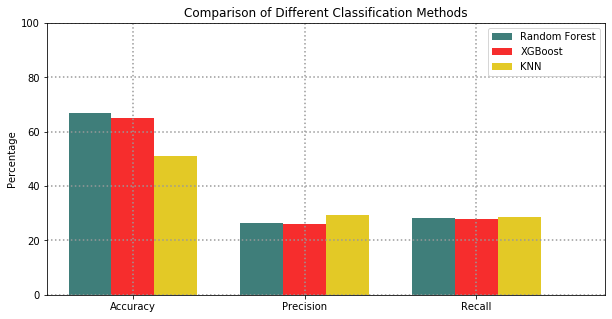

In [72]:
# Setting the positions and width for the bars
pos = list(range(len(df['Random Forest']))) 
width = 0.25 

#plt.figure(figsize=(14, 9))


# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        df['Random Forest'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=1, 
        # with color
        color='#3f7e7a', 
        # with label the first value in first_name
        label=df['first_name'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        df['XGBoost'],
        # of width
        width, 
        # with alpha 0.5
        alpha=1, 
        # with color
        color='#f62d2d', 
        # with label the second value in first_name
        label=df['first_name'][1]) 

# Create a bar with post_score data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        #using df['post_score'] data,
        df['KNN'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=1, 
        # with color
        color='#e3c926', 
        # with label the third value in first_name
        label=df['first_name'][2]) 

# Set the y axis label
ax.set_ylabel('Percentage')

# Set the chart's title
ax.set_title('Comparison of Different Classification Methods')

# Set the position of the x ticks
ax.set_xticks([p + 1 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df['first_name'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 100] )

# Adding the legend and showing the plot
plt.legend(['Random Forest', 'XGBoost', 'KNN'], loc='upper right')
plt.grid()
plt.grid(lw = 1.5, ls = 'dotted', c = "0.6", which = 'major')

#plt.savefig("./figs/" + plt.gca().get_title().replace("\n", "-") + ".png", bbox_inches="tight")

plt.show()